In [1]:
import sys
import os

# Ajouter le dossier parent au path
sys.path.append(os.path.abspath(os.path.join('..')))

# Ensuite tu peux importer ton module
import utils

In [2]:
df = utils.load_data("../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv")
df.shape

Data loaded successfully from ../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv


(333, 106)

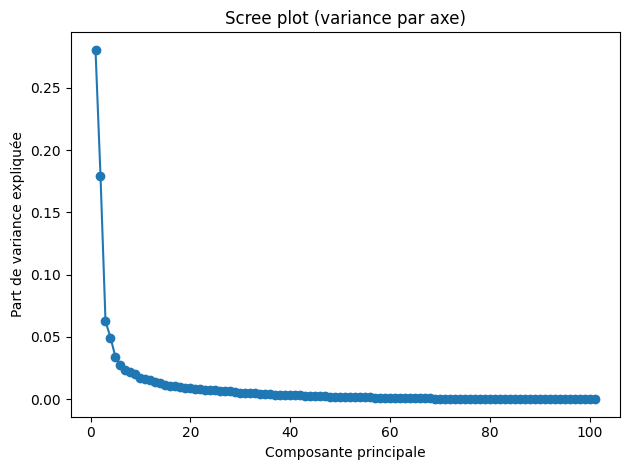

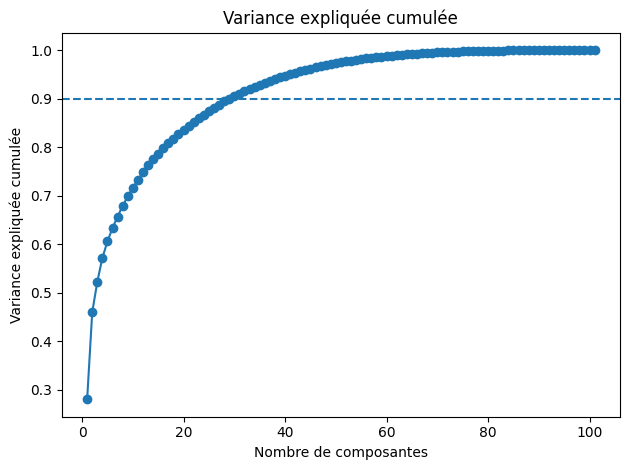

Nombre d'axes retenus pour atteindre 90% : k = 29


In [3]:
# pca_script.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def run_pca(df: pd.DataFrame, variance_threshold: float = 0.90, random_state: int = 0):
    # 1) Garde uniquement les colonnes numériques
    X = df.select_dtypes(include=[np.number]).copy()

    # 2) Imputation des NA (moyenne) + standardisation
    scaler = StandardScaler()
    X_proc = scaler.fit_transform(X)

    # 3) PCA complète (tous les axes), puis choix k via variance cumulée
    pca = PCA(n_components=None, random_state=random_state)
    scores_all = pca.fit_transform(X_proc)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    k = int(np.searchsorted(cumvar, variance_threshold) + 1)

    # 4) DataFrames utiles
    scores = pd.DataFrame(scores_all[:, :k],
                          index=df.index,
                          columns=[f"PC{i+1}" for i in range(k)])
    loadings = pd.DataFrame(pca.components_.T,
                            index=X.columns,
                            columns=[f"PC{i+1}" for i in range(pca.n_components_)])
    
    # --- Communauté (sum des loadings^2 sur les k axes retenus) ---
    load_k = pca.components_[:k, :].T            # (p variables) x (k axes)
    contrib_k = load_k ** 2
    communality = contrib_k.sum(axis=1)           # somme sur k
    communality_s = pd.Series(communality, index=X.columns, name="communality_k")

    expl_var = pd.DataFrame({
        "PC": [f"PC{i+1}" for i in range(pca.n_components_)],
        "ExplainedVar": pca.explained_variance_ratio_,
        "CumExplainedVar": cumvar
    })

    # 5) Graphes rapides
    # Scree plot
    plt.figure()
    plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker="o")
    plt.xlabel("Composante principale")
    plt.ylabel("Part de variance expliquée")
    plt.title("Scree plot (variance par axe)")
    plt.tight_layout()

    # Variance cumulée
    plt.figure()
    plt.plot(range(1, pca.n_components_ + 1), cumvar, marker="o")
    plt.axhline(variance_threshold, linestyle="--")
    plt.xlabel("Nombre de composantes")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée")
    plt.tight_layout()
    plt.show()

    print(f"Nombre d'axes retenus pour atteindre {variance_threshold*100:.0f}% : k = {k}")
    return {
        "pca": pca,
        "scaler": scaler,
        "scores": scores,        # coordonnées individus (PC1..PCk)
        "loadings": loadings,    # contributions/charges des variables
        "explained_variance": expl_var,
        "communality": communality_s

    }


results = run_pca(df, variance_threshold=0.90)


In [6]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

X_pca = results["scores"]
# Clustering BIRCH sur les composantes PCA
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=5)  # ajuste n_clusters et threshold
labels_birch = birch.fit_predict(X_pca)

# Évaluation
sil = silhouette_score(X_pca, labels_birch)
print(f"Silhouette (BIRCH sur PCA) = {sil:.3f}")

Silhouette (BIRCH sur PCA) = 0.169


In [7]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

X = X_pca.values if isinstance(X_pca, pd.DataFrame) else X_pca

thresholds = np.linspace(0.3, 1.5, 13)   # élargis la plage si besoin
Ks = range(2, 11)

best = None
for t in thresholds:
    for k in Ks:
        labels = Birch(threshold=t, n_clusters=k).fit_predict(X)
        counts = np.bincount(labels)
        if (counts >= 2).sum() < k:   # évite les singletons
            continue
        s = silhouette_score(X, labels)
        if not best or s > best[0]:
            best = (s, t, k)
        print(f"t={t:.2f} | k={k:02d} | min_size={counts.min():>2} | sil={s:.3f}")

print(f"\n Meilleur: silhouette={best[0]:.3f} avec threshold={best[1]:.2f}, n_clusters={best[2]}")


t=0.30 | k=02 | min_size=119 | sil=0.239
t=0.30 | k=03 | min_size=55 | sil=0.224
t=0.30 | k=04 | min_size=55 | sil=0.165
t=0.30 | k=05 | min_size=16 | sil=0.169
t=0.30 | k=06 | min_size=16 | sil=0.147
t=0.30 | k=07 | min_size= 7 | sil=0.151
t=0.30 | k=08 | min_size= 7 | sil=0.148
t=0.30 | k=09 | min_size= 7 | sil=0.126
t=0.30 | k=10 | min_size= 7 | sil=0.121
t=0.40 | k=02 | min_size=119 | sil=0.239
t=0.40 | k=03 | min_size=55 | sil=0.224
t=0.40 | k=04 | min_size=55 | sil=0.165
t=0.40 | k=05 | min_size=16 | sil=0.169
t=0.40 | k=06 | min_size=16 | sil=0.147
t=0.40 | k=07 | min_size= 7 | sil=0.151
t=0.40 | k=08 | min_size= 7 | sil=0.148
t=0.40 | k=09 | min_size= 7 | sil=0.126
t=0.40 | k=10 | min_size= 7 | sil=0.121
t=0.50 | k=02 | min_size=119 | sil=0.239
t=0.50 | k=03 | min_size=55 | sil=0.224
t=0.50 | k=04 | min_size=55 | sil=0.165
t=0.50 | k=05 | min_size=16 | sil=0.169
t=0.50 | k=06 | min_size=16 | sil=0.147
t=0.50 | k=07 | min_size= 7 | sil=0.151
t=0.50 | k=08 | min_size= 7 | sil=0.1

In [9]:
# 1) S'assurer que Plotly peut s'afficher dans le notebook
import plotly.io as pio
try:
    # Jupyter classique/JupyterLab
    pio.renderers.default = "notebook_connected"
except Exception:
    # VSCode
    pio.renderers.default = "browser"  # sinon mets "browser" en dernier recours

# 2) (re)générer la figure et afficher
import plotly.express as px
from sklearn.cluster import Birch
import pandas as pd
import numpy as np

X = results["scores"]
Xp = X.values
players = (df.loc[X.index, "player_name"].astype(str)
           if "player_name" in df.columns else X.index.astype(str))

birch_best = Birch(threshold=0.30, n_clusters=2)
labels_best = birch_best.fit_predict(Xp)

df_plot = X.copy()
df_plot["Cluster"] = labels_best.astype(str)
df_plot["Joueur"] = players.values

fig = px.scatter(
    df_plot, x="PC1", y="PC2",
    color="Cluster",
    hover_name="Joueur",
    title="BIRCH (threshold=0.30, n_clusters=2)",
)
fig.update_traces(marker=dict(size=7, line=dict(width=0.5, color="black")))
fig.update_layout(legend_title_text="Clusters")

fig.show()


In [7]:
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
import plotly.io as pio

# Pour que le graphique s'affiche
pio.renderers.default = "browser"

# --- Données PCA ---
X = results["scores"]
Xp = X.values

# Noms des joueurs
if "player_name" in df.columns:
    players = df.loc[X.index, "player_name"].astype(str)
else:
    players = X.index.astype(str)

# --- Clustering Ward ---
ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ward = ward.fit_predict(Xp)

# --- DataFrame pour Plotly ---
df_plot = X.copy()
df_plot["Cluster"] = labels_ward.astype(str)
df_plot["Joueur"] = players.values

# --- Graphique interactif ---
fig = px.scatter(
    df_plot,
    x="PC1", y="PC2",
    color="Cluster",
    hover_name="Joueur",
    title="Ward (Agglomerative, n_clusters=2)",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(marker=dict(size=7, line=dict(width=0.5, color='black')))
fig.update_layout(legend_title_text="Clusters")

fig.show()


[2] Sandbox: CanCreateUserNamespace() clone() failure: EPERM
